In [1]:
__depends__ = [
    "../data/sr15_scenarios/sr15_scenarios.csv",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UVIC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_BERN.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_LLNL.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CCSM1.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_CLIMBER.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_MPI.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_FRCGC.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_UMD2.CFG",
    "../data/magicc-cfgs/MAGTUNE_C4MIP_HADLEY.CFG",
    "utils_openscm.py",
    "utils_magcfg.py",
    "utils_config.py",
    "utils_latex.py",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_CCCMA_CGCM3_1_T47.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_CNRM_CM3.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_CSIRO_MK3_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GFDL_CM2_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GFDL_CM2_1.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GISS_MODEL_E_H.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_GISS_MODEL_E_R.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_IAP_FGOALS1_0_G.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_INMCM3_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_IPSL_CM4.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MIROC3_2_HIRES.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MIROC3_2_MEDRES.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MIUB_ECHO_G.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MPI_ECHAM5.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_MRI_CGCM2_3_2A.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_NCAR_CCSM3_0.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_NCAR_PCM1.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_UKMO_HADCM3.CFG",
    "../data/magicc-cfgs/MAGTUNE_FULLTUNE_UKMO_HADGEM1.CFG",
]
__dest__ = [
    "../outputs/diagnosis_runs.h5",
    "../sections/custom_commands_diagnosis_runs.tex",
    "../figures/zec_diagnosis_runs.pdf",
]

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Cell above is scons stuff to make sure our dependency tree work. We put a renaming in the cell below to make it clearer what is what.

In [3]:
SCENARIO_PATH = __depends__[0]
CARBON_CYCLE_FILES = {
    "UVIC": __depends__[1],
    "BERN": __depends__[2],
    "LLNL": __depends__[3],
    "CCSM1": __depends__[4],
    "CLIMBER": __depends__[5],
    "MPI": __depends__[6],
    "FRCGC": __depends__[7],
    "UMD2": __depends__[8],
    "HADLEY": __depends__[9],
}
OCEAN_TUNING_FILES = {
    "CCCMA_CGCM3_1_T47": __depends__[14],
    "CNRM_CM3": __depends__[15],
    "CSIRO_MK3_0": __depends__[16],
    "GFDL_CM2_0": __depends__[17],
    "GFDL_CM2_1": __depends__[18],
    "GISS_MODEL_E_H": __depends__[19],
    "GISS_MODEL_E_R": __depends__[20],
    "IAP_FGOALS1_0_G": __depends__[21],
    "INMCM3_0": __depends__[22],
    "IPSL_CM4": __depends__[23],
    "MIROC3_2_HIRES": __depends__[24],
    "MIROC3_2_MEDRES": __depends__[25],
    "MIUB_ECHO_G": __depends__[26],
    "MPI_ECHAM5": __depends__[27],
    "MRI_CGCM2_3_2A": __depends__[28],
    "NCAR_CCSM3_0": __depends__[29],
    "NCAR_PCM1": __depends__[30],
    "UKMO_HADCM3": __depends__[31],
    "UKMO_HADGEM1": __depends__[32],
}
OUTPUT_RUNS = __dest__[0]
LATEX_COMMANDS_TEX = __dest__[1]
ZEC_DIAGNOSIS_RUNS_FIGURES = __dest__[2]

<IPython.core.display.Javascript object>

# Diagnosis Runs

In this notebook we perform the runs which examine whether diagnosing TCRE and ZEC in experiments with a 1%/yr rising CO$_2$ concentration experiment and abrupt drop experiments respectively, both without land use change, is introducing any bias.

## Imports

In [4]:
import os
import datetime
from distutils.util import strtobool

import numpy as np
import pandas as pd
from openscm.scmdataframe import ScmDataFrame, df_append
from pymagicc.io import read_cfg_file, MAGICCData
from pymagicc.core import MAGICC6, _get_openscm_var_from_filepath
import progressbar

from utils_latex import new_latex_command
from utils_openscm import save_scmdataframe, run_magicc6_with_scenarios
from utils_magcfg import get_carbon_cycle_cfgs, get_ocean_tuning_cfgs
from utils_config import TEST_RUN

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting Config

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from utils_plotting import setup, SAVE_KWARGS

setup()

<IPython.core.display.Javascript object>

## Constants

In [6]:
SHOW_PLOTS = False and not strtobool(
    os.getenv("CI", "False")
)  # turn on if using the notebooks interactively

CARBON_CYCLES = get_carbon_cycle_cfgs(CARBON_CYCLE_FILES)
OCEAN_TUNINGS = get_ocean_tuning_cfgs(OCEAN_TUNING_FILES)

<IPython.core.display.Javascript object>

## Read in scenarios

In [7]:
raw_scenarios = ScmDataFrame(SCENARIO_PATH)
assert raw_scenarios.timeseries().index.get_level_values("region").unique() == ["World"]

<IPython.core.display.Javascript object>

## Filter scenarios

ZEC can only be diagnosed from scenarios whose emissions reach zero. Hence we filter for those scenarios here. Given our focus on ZEC and TCRE in low emissions scenarios we find this filtering to be a justifiable choice. 

Diagnosing a ZEC, by definition, requires that emissions are not negative. Hence we also replace all negative emissions with zeros. As we're only interested in ZEC and TCRE in response to CO$_2$ emissions only, we set all other emissions to zero. We do, however, include land use change emissions because the impact of these is included in the definition of the remaining carbon budget (although it is not normally included in the definition of TCRE and ZEC so this is a clear potential cause of difference).

In [8]:
scenarios_df = raw_scenarios.to_iamdataframe().data.copy()

<IPython.core.display.Javascript object>

In [9]:
def has_zero_co2_emissions(r):
    co2i_emms = r[
        r["variable"] == "Emissions|CO2|MAGICC Fossil and Industrial"
    ].set_index("time")
    co2b_emms = r[r["variable"] == "Emissions|CO2|MAGICC AFOLU"].set_index("time")
    co2_emms_value = co2i_emms["value"] + co2b_emms["value"]

    return (co2_emms_value <= 0).any()


scenarios_filtered_df = (
    scenarios_df.groupby(["model", "scenario"])
    .filter(has_zero_co2_emissions)
    .copy()
    .reset_index(drop=True)
)

scenarios_zero_co2_emms = ScmDataFrame(scenarios_filtered_df)

<IPython.core.display.Javascript object>

In [10]:
diagnosis_scens = []

for label, df in scenarios_filtered_df.groupby(["model", "scenario"]):
    sdf = df.sort_values("time")
    co2b = sdf[sdf["variable"] == "Emissions|CO2|MAGICC AFOLU"].set_index("time")
    co2i = sdf[
        sdf["variable"] == "Emissions|CO2|MAGICC Fossil and Industrial"
    ].set_index("time")

    co2emms_value = co2b["value"] + co2i["value"]
    first_zero = co2emms_value[co2emms_value <= 0].index.min()

    sdf.loc[
        (
            (sdf["variable"] == "Emissions|CO2|MAGICC Fossil and Industrial")
            | (sdf["variable"] == "Emissions|CO2|MAGICC AFOLU")
        )
        & (sdf["time"] >= first_zero),
        "value",
    ] = 0

    sdf.loc[
        (
            (sdf["variable"] != "Emissions|CO2|MAGICC Fossil and Industrial")
            & (sdf["variable"] != "Emissions|CO2|MAGICC AFOLU")
        ),
        "value",
    ] = 0
    sdf.loc[:, "scenario"] = sdf["scenario"].apply(
        lambda x: "{}_ZEC_diagnosis".format(x)
    )

    diagnosis_scens.append(sdf)

scenarios_filtered_zec_diagnosis_df = pd.concat(diagnosis_scens)

<IPython.core.display.Javascript object>

In [11]:
scale_factor = [
    0.2,
    0.4,
    #     0.7
]
scale_factor_inverse_str = [
    1 / v if int(1 / v) != 1 / v else int(1 / v) for v in sorted(scale_factor)[::-1]
]
scale_factor_inverse_str = ", ".join(
    [str(v) for v in scale_factor_inverse_str[:-1]]
) + " and {}".format(scale_factor_inverse_str[-1])
with open(LATEX_COMMANDS_TEX, "w") as f:
    f.write(new_latex_command("spedupscenariofactors", scale_factor_inverse_str))

<IPython.core.display.Javascript object>

In [12]:
diagnosis_scens_fractions = []
end_hist_year = 2010

for s in scale_factor:
    idx = list(set(scenarios_filtered_zec_diagnosis_df.columns) - {"value", "time"})
    fdf = scenarios_filtered_zec_diagnosis_df.pivot_table(
        values="value", columns="time", index=idx
    )

    def get_new_year(x, end_hist_year=end_hist_year, scaling=s):
        if x <= datetime.datetime(end_hist_year, 1, 1):
            return x
        else:
            return datetime.datetime(end_hist_year, 1, 1) + scaling * (
                x - datetime.datetime(end_hist_year, 1, 1)
            )

    fdf.columns = fdf.columns.map(get_new_year)
    fdf.columns.name = None

    fdf.loc[:, datetime.datetime(2100, 1, 1)] = 0

    fdf = fdf.T.resample("AS").last().T

    fdf = fdf.reset_index().melt(id_vars=fdf.index.names, var_name="time")
    fdf.loc[:, "scenario"] = fdf["scenario"].apply(
        lambda x: "{}_xaxis_times_{}".format(x, s)
    )

    diagnosis_scens_fractions.append(fdf)

scenarios_filtered_zec_diagnosis_and_fractions_df = pd.concat(
    diagnosis_scens + diagnosis_scens_fractions, sort=False
)

<IPython.core.display.Javascript object>

In [13]:
scenarios = ScmDataFrame(scenarios_filtered_zec_diagnosis_and_fractions_df)
scenarios.tail()

time                                                                                                                          2000-01-01  \
model             scenario                                           region variable        unit          climate_model todo               
WITCH-GLOBIOM_4_4 CD-LINKS_NPi2020_400_ZEC_diagnosis_xaxis_times_0.4 World  Emissions|NMVOC Mt NMVOC / yr unspecified   SET          0.0   
                                                                            Emissions|NOx   Mt N / yr     unspecified   SET          0.0   
                                                                            Emissions|OC    Mt OC / yr    unspecified   SET          0.0   
                                                                            Emissions|SF6   kt SF6 / yr   unspecified   SET          0.0   
                                                                            Emissions|SOx   Mt S / yr     unspecified   SET          0.0   

time                                                                                                                          2001-01-01  \
model             scenario                                           region variable        unit          climate_model todo               
WITCH-GLOBIOM_4_4 CD-LINKS_NPi2020_400_ZEC_diagnosis_xaxis_times_0.4 World  Emissions|NMVOC Mt NMVOC / yr unspecified   SET          0.0   
                                                                            Emissions|NOx   Mt N / yr     unspecified   SET          0.0   
                                                                            Emissions|OC    Mt OC / yr    unspecified   SET          0.0   
                                                                            Emissions|SF6   kt SF6 / yr   unspecified   SET          0.0   
                                                                            Emissions|SOx   Mt S / yr     unspecified   SET          0.0   

time                                                                                                                          2002-01-01  \
model             scenario                                           region variable        unit          climate_model todo               
WITCH-GLOBIOM_4_4 CD-LINKS_NPi2020_400_ZEC_diagnosis_xaxis_times_0.4 World  Emissions|NMVOC Mt NMVOC / yr unspecified   SET          0.0   
                                                                            Emissions|NOx   Mt N / yr     unspecified   SET          0.0   
                                                                            Emissions|OC    Mt OC / yr    unspecified   SET          0.0   
                                                                            Emissions|SF6   kt SF6 / yr   unspecified   SET          0.0   
                                                                            Emissions|SOx   Mt S / yr     unspecified   SET          0.0   

time                                                                                                                          2003-01-01  \
model             scenario                                           region variable        unit          climate_model todo               
WITCH-GLOBIOM_4_4 CD-LINKS_NPi2020_400_ZEC_diagnosis_xaxis_times_0.4 World  Emissions|NMVOC Mt NMVOC / yr unspecified   SET          0.0   
                                                                            Emissions|NOx   Mt N / yr     unspecified   SET          0.0   
                                                                            Emissions|OC    Mt OC / yr    unspecified   SET          0.0   
                                                                            Emissions|SF6   kt SF6 / yr   unspecified   SET          0.0   
                                                                            Emissions|SOx   Mt S / yr     unspecified   SET          0.0   

time                                                                        

<IPython.core.display.Javascript object>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


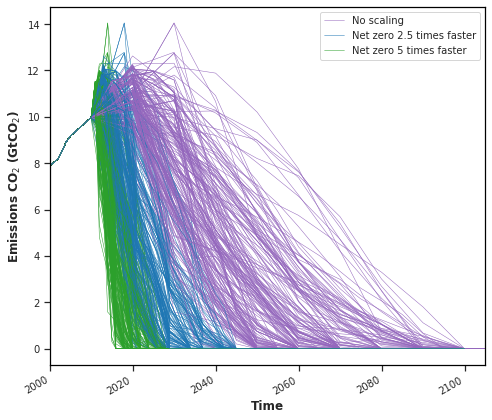

<IPython.core.display.Javascript object>

In [14]:
colours = {"times_0.2": "tab:green", "times_0.4": "tab:blue", "other": "tab:purple"}
tempdf = scenarios.filter(variable="Emissions|CO2|*", region="World").timeseries()
ax = plt.figure().add_subplot(111)
have_labeled = []
for i, (label, df) in enumerate(tempdf.groupby(["model", "scenario", "unit"])):
    for c in colours:
        if c in label[1]:
            colour = colours[c]
            legend_key = (
                "Net zero 2.5 times faster"
                if c == "times_0.4"
                else "Net zero 5 times faster"
            )
            break
    else:
        colour = colours["other"]
        legend_key = "No scaling"

    legend_key = legend_key if legend_key not in have_labeled else None
    have_labeled.append(legend_key)
    df.dropna(axis="columns").sum().plot(ax=ax, label=legend_key, lw=0.5, color=colour)

handles, labels = ax.get_legend_handles_labels()
handles_ordered = []
labels_ordered = []
new_order = ["No scaling", "Net zero 2.5 times faster", "Net zero 5 times faster"]
for new_label in new_order:
    for i, h in enumerate(handles):
        if labels[i] != new_label:
            continue

        handles_ordered.append(h)
        labels_ordered.append(labels[i])

ax.legend(handles_ordered, labels_ordered)
ax.set_xlabel("Time")
ax.set_ylabel(r"Emissions CO$_2$ (GtCO$_2$)")
plt.tight_layout()
plt.savefig(ZEC_DIAGNOSIS_RUNS_FIGURES, **SAVE_KWARGS)

In [15]:
if SHOW_PLOTS:
    scenarios.filter(
        variable="Emissions|CO2|MAGICC Fossil and Industrial", region="World"
    ).line_plot(linewidth=0.5)
    scenarios.filter(variable="Emissions|CO2|MAGICC AFOLU", region="World").line_plot(
        linewidth=0.5
    )

<IPython.core.display.Javascript object>

## TCRE/ZEC in low emissions scenarios

Here we run MAGICC with CO2 forcing only for the filtered scenarios above for a number of carbon cycle settings.

In [16]:
RUN_SETTINGS = {
    "endyear": scenarios["time"].max().year,
    "rf_total_constantafteryr": 5000,
    "rf_total_runmodus": "CO2",
    "co2_switchfromconc2emis_year": 1750,
    "co2_tempfeedback_yrstart": 1750,
    "co2_fertilization_yrstart": 1750,
    "pf_apply": 0,
}
DIAGNOSIS_VARS_TO_KEEP = [
    "Surface Temperature",
    "Emissions|CO2|MAGICC Fossil and Industrial",
    "Emissions|CO2|MAGICC AFOLU",
    "Inverse Emissions|CO2|MAGICC Fossil and Industrial",
    "Radiative Forcing",
    "Land to Air Flux|CO2|MAGICC Permafrost",
    "Atmospheric Concentrations|CO2",
]

<IPython.core.display.Javascript object>

In [17]:
diagnosis_runs = []
for j, (cc, cc_config) in enumerate(CARBON_CYCLES.items()):
    if TEST_RUN and j > 2 and cc != "default":
        continue
    print(cc)
    run_settings = {**RUN_SETTINGS, **cc_config}
    run_results = run_magicc6_with_scenarios(
        scenarios, run_settings, test_run=TEST_RUN, vars_to_keep=DIAGNOSIS_VARS_TO_KEEP
    )
    run_results.set_meta(cc, name="carbon_cycle_tuning")
    diagnosis_runs.append(run_results)

for j, (oc, oc_config) in enumerate(OCEAN_TUNINGS.items()):
    if TEST_RUN and j > 2 and oc != "default":
        continue
    print(oc)
    run_settings = {**RUN_SETTINGS, **oc_config}
    run_results = run_magicc6_with_scenarios(
        scenarios, run_settings, test_run=TEST_RUN, vars_to_keep=DIAGNOSIS_VARS_TO_KEEP
    )
    run_results.set_meta(oc, name="ocean_tuning")
    diagnosis_runs.append(run_results)
    
diagnosis_runs = df_append(diagnosis_runs)

/ |#                                                  | 0 Elapsed Time: 0:00:00

UVIC


| |                                               # | 614 Elapsed Time: 0:09:33
/ |#                                                  | 0 Elapsed Time: 0:00:00

BERN


| |           #                                     | 614 Elapsed Time: 0:09:37
/ |#                                                  | 0 Elapsed Time: 0:00:00

LLNL


| |                                     #           | 614 Elapsed Time: 0:09:41
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCSM1


| |                                   #             | 614 Elapsed Time: 0:09:41
/ |#                                                  | 0 Elapsed Time: 0:00:00

CLIMBER


| |                           #                     | 614 Elapsed Time: 0:09:45
/ |#                                                  | 0 Elapsed Time: 0:00:00

MPI


| |                 #                               | 614 Elapsed Time: 0:09:36
/ |#                                                  | 0 Elapsed Time: 0:00:00

FRCGC


| |                           #                     | 614 Elapsed Time: 0:09:35
/ |#                                                  | 0 Elapsed Time: 0:00:00

UMD2


| |                                   #             | 614 Elapsed Time: 0:09:34
/ |#                                                  | 0 Elapsed Time: 0:00:00

HADLEY


| |   #                                             | 614 Elapsed Time: 0:09:38
/ |#                                                  | 0 Elapsed Time: 0:00:00

default


| |                #                                | 614 Elapsed Time: 0:09:39
/ |#                                                  | 0 Elapsed Time: 0:00:00

CCCMA_CGCM3_1_T47


| |            #                                    | 614 Elapsed Time: 0:09:36
/ |#                                                  | 0 Elapsed Time: 0:00:00

CNRM_CM3


| |            #                                    | 614 Elapsed Time: 0:09:49
/ |#                                                  | 0 Elapsed Time: 0:00:00

CSIRO_MK3_0


| |                           #                     | 614 Elapsed Time: 0:09:45
/ |#                                                  | 0 Elapsed Time: 0:00:00

GFDL_CM2_0


| |                                        #        | 614 Elapsed Time: 0:09:42
/ |#                                                  | 0 Elapsed Time: 0:00:00

GFDL_CM2_1


| |        #                                        | 614 Elapsed Time: 0:09:39
/ |#                                                  | 0 Elapsed Time: 0:00:00

GISS_MODEL_E_H


| |                                #                | 614 Elapsed Time: 0:09:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

GISS_MODEL_E_R


| |                                  #              | 614 Elapsed Time: 0:09:44
/ |#                                                  | 0 Elapsed Time: 0:00:00

IAP_FGOALS1_0_G


| |                             #                   | 419 Elapsed Time: 0:06:34

In [18]:
diagnosis_runs.timeseries().head()

time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1765-01-01  \
model   scenario                             region                          variable                       unit carbon_cycle_tuning climate_model co2_detrituspool_initial co2_feedbackfactor_detritus co2_feedbackfactor_gpp co2_feedbackfactor_respiration co2_feedbackfactor_soil co2_fertilization_factor co2_fertilization_method co2_fertilization_yrstart co2_fraction_detritus_2_soil co2_fraction_gpp_2_detritus co2_fraction_gpp_2_plant co2_fraction_plant_2_detritus co2_gpp_initial co2_plantpool_initial co2_respiration_initial co2_soilpool_initial co2_switchfromconc2emis_year co2_tempfeedback_yrstart core_amplify_ocn2land_heatxchng core_climatesensitivity core_delq2xco2 core_feedback_qsensitivity core_heatxchange_landocean core_heatxchange_northsouth core_hemisfraction_nh_land core_hemisfraction_sh_land core_rlo core_verticaldiff_top_dkdt core_verticaldiffusivity endyear ocean_tuning oceancc_scale_gasxchange oceancc_scale_impulseresponse oceancc_tempfeedback pf_apply rf_total_constantafteryr rf_total_runmodus todo               
AIM_2_0 ADVANCE_2020_1.5C-2100_ZEC_diagnosis World                           Atmospheric Concentrations|CO2 ppm  FRCGC               MAGICC6       32.6689                  0.399463                    0.024352               -0.199991                      0.223615                0.262525                 1.998614                 1750                      0.061806                     0.226456                    0.659712                 0.998999                      48.1558         484.2099              8.908823                592.1234             1750                         1750                     NaN                             NaN                     NaN            NaN                        NaN                        NaN                         NaN                        NaN                        NaN      NaN                        NaN                      2105    NaN          1.285673                 1.119896                      0.000041             0        5000                     CO2               N/A    278.05158   
                                             World|Northern Hemisphere|Land  Atmospheric Concentrations|CO2 ppm  FRCGC               MAGICC6       32.6689                  0.399463                    0.024352               -0.199991                      0.223615                0.262525                 1.998614                 1750                      0.061806                     0.226456                    0.659712                 0.998999                      48.1558         484.2099              8.908823                592.1234             1750                         1750                     NaN                             NaN                     NaN            NaN                        NaN                        NaN                         NaN                        NaN                        NaN      NaN                        NaN                      2105    N

<IPython.core.display.Javascript object>

In [19]:
diagnosis_runs["variable"].unique()

array(['Atmospheric Concentrations|CO2', 'Emissions|CO2|MAGICC AFOLU',
       'Emissions|CO2|MAGICC Fossil and Industrial', 'Radiative Forcing',
       'Surface Temperature'], dtype=object)

<IPython.core.display.Javascript object>

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


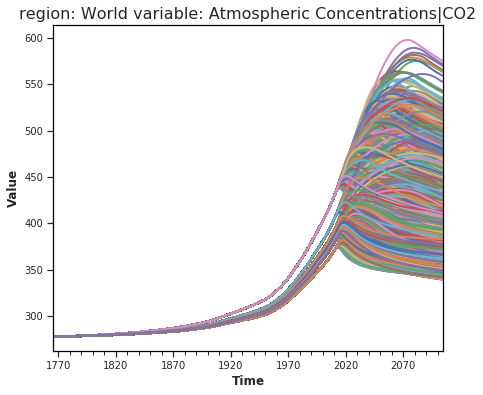

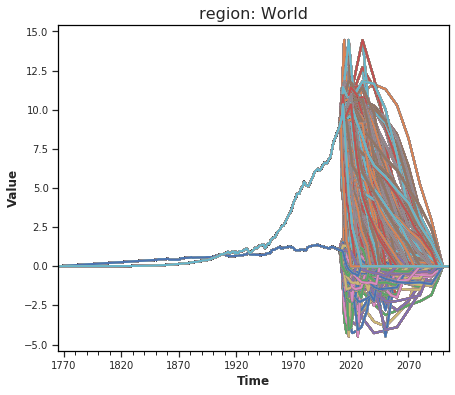

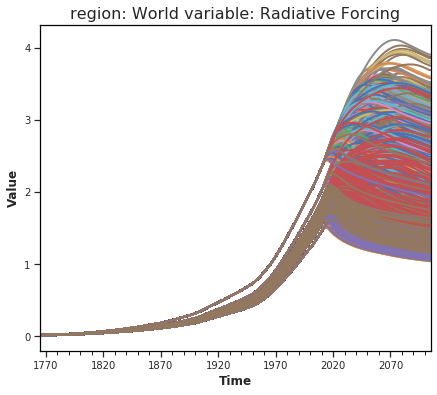

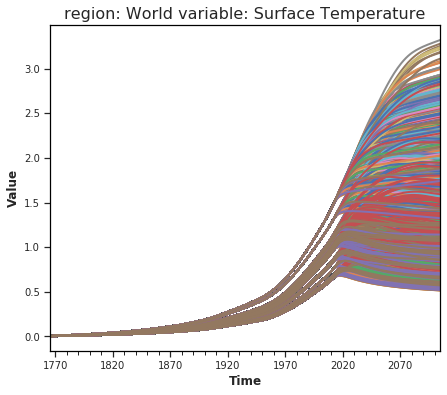

<IPython.core.display.Javascript object>

In [20]:
pdf = ScmDataFrame(diagnosis_runs.timeseries().reset_index().fillna("hack around pyam"))
pdf.filter(variable="*Conc*CO2", region="World").line_plot(x="time")
pdf.filter(variable="Emis*CO2*", region="World").line_plot(x="time")
pdf.filter(variable="Radiative Forcing", region="World").line_plot(
    x="time", color="scenario"
)
pdf.filter(variable="Surface Temperature", region="World").line_plot(
    x="time", color="scenario"
)

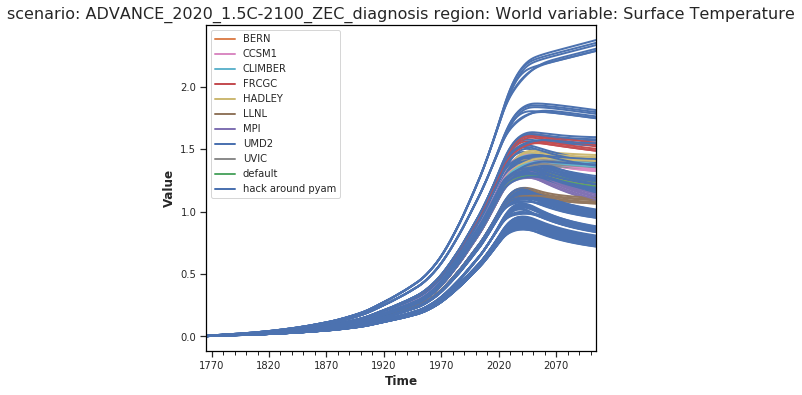

<IPython.core.display.Javascript object>

In [21]:
pdf.filter(
    scenario="ADVANCE_2020_1.5C-2100_ZEC_diagnosis",
    variable="Surface Temperature",
    region="World",
).line_plot(color="carbon_cycle_tuning")

## Other non-CO$_2$ diagnosis options

The question we really want to answer is, how much of the warming from an all forcers run can we attribute to the impact of non-CO$_2$ emissions. 

Unfortunately, as warming evolves over time and we're not really interested in equilibrium warming for carbon budget questions (where, in mitigation scenarios, our peak warming is a non-equilibrium state of the climate) we cannot avoid including the question of, 'When?', as we ask, 'What is the contribution of non-CO$_2$'. Fortunately, the carbon budget framework nicely answers the question of, 'When?', with, 'At the point where CO$_2$ emissions reach net zero', because all of the effects thereafter are captured in the zero emissions commitment and the assumption that the contribution of non-CO$_2$ forcers is \leq 0 after we reach peak warming (if it's not, the whole carbon budget to peak warming framework goes out the window so diagnosing the non-CO$_2$ contribution becomes the least of our problems). This when component does push us into some cases which can initially feel non-intuitive. For example, over the time period of a decade, the non-CO$_2$ contribution is negative i.e. a cooling. Whilst this isn't initially intuitive, it doesn't take much thought to realise that removing all non-CO$_2$ emissions would initially cause a warming as the negative aerosol radiative forcing would dissipate completely whilst other positive forcings would remain. This is an unavoidable complication which arises due to the differing timescales over which emissions of different species have an impact on surface temperatures (and the climate more broadly).

Non-CO$_2$ diagnosis is also hard because you can't actually separate the CO$_2$ and non-CO$_2$ contributions completely. They are coupled and hence any measure of non-CO$_2$ will be imperfect as it's a non-linear system. 

One bound on the impact of non-CO$_2$ can be estimated by looking at the difference between two experiments: one emissions driven run with all forcers, the other run all forcers over the historical then with CO$_2$ radiative forcing only from the output of the all forcers experiment. This is one bound (generally the lower except for weird edge cases which don't apply to the real world, yet) as the temperature estimate for the CO$_2$-only run includes the effect of all feedbacks from the non-CO$_2$ emissions onto the carbon cycle, decay of methane to CO$_2$ etc (you are in effect attributing the entire CO$_2$ forcing to CO$_2$ emissions when we know part of it is due to non-CO$_2$ emissions). 

The upper bound on the impact of non-CO$_2$ can be estimated by looking at the difference between two experiments: one emissions driven run with all forcers, the other run with all forcers over the historical period then CO$_2$ emissions only. This is the upper bound as the temperature estimate for the CO$_2$-only run excludes the effect of all feedbacks from non-CO$_2$ emissions onto the carbon cycle, decay of methane to CO$_2$ etc.  The extra complication here is working out how to spin up your model. In an ideal world, you would spin up following the same historical pathway in both cases before switching as we move into the projections. The difficulty is what to do about the drop in radiative forcing as you transition between the two...

For a model whose RF --> T step is non-linear and which has T \propto RF^k, k > 1 (like MAGICC I think), this method will still be biased low as we won't see the impact of adding the two RFs together (and part of this impact should be attributed to each contributing timeseries). In other words, if you took the total RF timeseries and ran it through your model, you would get a temperature timeseries which was greater than if you summed the two temperature timeseries coming out of separate all RF and all - CO$_2$ RF experiments. However I suspect this non-linear effect to be second or third order in importance...

The other dimension we can investigate is when the non-CO$_2$ RF kicks in. Rather than using radiative forcings to turn the impact of non-CO$_2$ forcers 'off', we can instead turn their emissions off at the start of the projection period and let temperatures respond from there. Such an experiment probes the timescale over which non-CO$_2$ emissions are actually having an impact and is the only way, really, for us to see that over a short period non-CO$_2$ is having a cooling effect whilst over the longer term it has a warming effect.

In [22]:
if SHOW_PLOTS:
    scenarios.filter(variable="Emissions|BC", year=range(2010, 2021)).line_plot()

<IPython.core.display.Javascript object>

In [23]:
def get_co2_only_scen(idf, drop_year):
    co2_only_scen = idf.timeseries()
    for year in range(co2_only_scen.columns.min().year, drop_year + 1):
        yrdt = datetime.datetime(year, 1, 1)
        if yrdt not in co2_only_scen:
            co2_only_scen[yrdt] = np.nan

    co2_only_scen = co2_only_scen.sort_index(axis="columns")
    co2_only_scen = co2_only_scen.interpolate(method="index", axis=1)
    co2_only_scen = ScmDataFrame(co2_only_scen)

    tdf1 = co2_only_scen.filter(year=range(1, drop_year))
    tdf2 = (
        co2_only_scen.filter(variable="Emissions|CO2*", keep=False)
        .filter(year=range(drop_year, 3000))
        .timeseries()
    )
    tdf2.loc[:, :] = 0

    tdf3 = co2_only_scen.filter(variable="Emissions|CO2*", year=range(drop_year, 3000))
    tdf = df_append(
        [tdf1, tdf2, tdf3], duplicate_msg=False  # false positive in scmdataframe, see
    ).timeseries()
    co2_only_scen = ScmDataFrame(tdf)

    return co2_only_scen


def get_defaults_ref_year_concs():
    with MAGICC6() as magicc:
        magicc6_default_config = magicc.update_config(filename="MAGCFG_USER.CFG")[
            "nml_allcfgs"
        ]

        magicc6_rf_ref_year = magicc6_default_config["rf_preind_referenceyr"]
        magicc6_rf_ref_year_concs = {}
        for file in os.listdir(magicc.run_dir):
            read_file = (
                ("HISTRCP" in file)
                and ("CONC.IN" in file)
                and (("CO2" in file) or ("N2O" in file) or ("CH4" in file))
            )
            if read_file:
                var = _get_openscm_var_from_filepath(file)
                hist = MAGICCData(os.path.join(magicc.run_dir, file))
                magicc6_rf_ref_year_concs[var] = (
                    hist.filter(year=magicc6_rf_ref_year, region="World")
                    .timeseries()
                    .values[0][0]
                )

    return {"defaults": magicc6_default_config, "ref_concs": magicc6_rf_ref_year_concs}


def get_file_writing_df(base_df, new_var_name=None):
    if new_var_name is None:
        new_var_name = base_df["variable"].unique()
        assert len(new_var_name) == 1
        new_var_name = new_var_name[0]

    file_writing_ids = ["model", "scenario", "region", "variable", "unit"]

    tdf = base_df.timeseries()

    all_ids = tdf.index.names
    drop_cols = set(all_ids) - set(file_writing_ids)

    tdf = tdf.reset_index().drop(drop_cols, axis="columns").set_index(file_writing_ids)
    tdf.index = tdf.index.set_levels(
        tdf.index.levels[tdf.index.names.index("variable")].map(lambda x: new_var_name),
        level=tdf.index.names.index("variable"),
    )

    return MAGICCData(tdf)


def get_abrupt_drop_df(base_df, variables, drop_year, keep_world=False):
    out_df = []
    for drop_var in variables:
        if drop_var not in base_df["variable"].unique():
            print(drop_var)
        vdf = get_file_writing_df(
            base_df.filter(variable=drop_var).filter(region="World", keep=keep_world)
        ).timeseries()

        replace_cols = vdf.columns.map(lambda x: x.year >= drop_year)
        vdf.loc[:, replace_cols] = np.repeat(
            vdf.iloc[:, 0].values[:, np.newaxis], sum(replace_cols), axis=1
        )
        out_df.append(vdf)

    return pd.concat(out_df)


def hotfix_aggregate_for_file_writing(base_df, new_name, components):
    # cleaner interface available in pyam 0.2.0, update if time/worth it
    for v in components:
        vdf = get_file_writing_df(
            base_df.filter(variable=v), new_var_name=new_name
        ).timeseries()
        try:
            df += vdf
        except:
            df = vdf.copy()

    return ScmDataFrame(df)


def all_forcers_run(s, vars_to_keep, dc):
    all_forcers_settings = {
        "endyear": 2105,
        "pf_apply": 0,
        "out_permafrost": 1,
        "out_forcing": 1,
        "out_concentrations": 1,
        "rf_total_runmodus": "ALL",
        "co2_switchfromconc2emis_year": dc["co2_switchfromconc2emis_year"],
        "co2_tempfeedback_yrstart": dc["co2_tempfeedback_yrstart"],
        "co2_fertilization_yrstart": dc["co2_fertilization_yrstart"],
        "ch4_switchfromconc2emis_year": dc["ch4_switchfromconc2emis_year"],
        "n2o_switchfromconc2emis_year": dc["n2o_switchfromconc2emis_year"],
        "fgas_switchfromconc2emis_year": dc["fgas_switchfromconc2emis_year"],
        "mhalo_switch_conc2emis_yr": dc["mhalo_switch_conc2emis_yr"],
        "rf_extra_read": 0,
        "rf_tropoz_constantafteryr": dc["rf_tropoz_constantafteryr"],
        "rf_stratoz_constantafteryr": dc["rf_stratoz_constantafteryr"],
    }

    res_all = run_magicc6_with_scenarios(
        s, all_forcers_settings, vars_to_keep=vars_to_keep
    )
    res_all.set_meta("all_forcers", name="zn_nonco2_diagnosis_option")

    return res_all


def get_custom_concs(
    all_forcers_results, dy, magicc6_rf_ref_year_concs, copy_co2_conc=False
):
    montreal_ghgs = get_abrupt_drop_df(
        all_forcers_results,
        [
            "Atmospheric Concentrations|CFC11",
            "Atmospheric Concentrations|CFC12",
            "Atmospheric Concentrations|CFC113",
            "Atmospheric Concentrations|CFC114",
            "Atmospheric Concentrations|CFC115",
            "Atmospheric Concentrations|CCl4",
            "Atmospheric Concentrations|CH3CCl3",
            "Atmospheric Concentrations|HCFC22",
            "Atmospheric Concentrations|HCFC141b",
            "Atmospheric Concentrations|HCFC142b",
            "Atmospheric Concentrations|Halon1211",
            "Atmospheric Concentrations|Halon1202",
            "Atmospheric Concentrations|Halon1301",
            "Atmospheric Concentrations|Halon2402",
            "Atmospheric Concentrations|CH3Br",
            "Atmospheric Concentrations|CH3Cl",
        ],
        dy,
        keep_world=True,
    )

    other_ghgs = get_abrupt_drop_df(
        all_forcers_results,
        [
            "Atmospheric Concentrations|CH4",
            "Atmospheric Concentrations|N2O",
            "Atmospheric Concentrations|CF4",
            "Atmospheric Concentrations|C2F6",
            "Atmospheric Concentrations|C6F14",
            "Atmospheric Concentrations|HFC23",
            "Atmospheric Concentrations|HFC32",
            "Atmospheric Concentrations|HFC4310",
            "Atmospheric Concentrations|HFC125",
            "Atmospheric Concentrations|HFC134a",
            "Atmospheric Concentrations|HFC143a",
            "Atmospheric Concentrations|HFC227ea",
            "Atmospheric Concentrations|HFC245fa",
            "Atmospheric Concentrations|SF6",
        ],
        dy,
        keep_world=False,
    )
    concs = [montreal_ghgs, other_ghgs]
    if copy_co2_conc:
        prescr_concs_co2 = get_file_writing_df(
            all_forcers_results.filter(
                variable="Atmospheric Concentrations|CO2"
            ).filter(region="World", keep=False)
        ).timeseries()
        concs.append(prescr_concs_co2)

    custom_concs = pd.concat(concs)

    pi_years = range(1750, 1765)
    for y in pi_years:
        custom_concs[datetime.datetime(y, 1, 1)] = custom_concs.iloc[:, 0]
        custom_concs = custom_concs.sort_index(axis="columns")

        custom_concs.loc[
            custom_concs.index.get_level_values("variable").isin(
                ["Atmospheric Concentrations|CO2"]
            ),
            datetime.datetime(y, 1, 1),
        ] = magicc6_rf_ref_year_concs["Atmospheric Concentrations|CO2"]
        custom_concs.loc[
            custom_concs.index.get_level_values("variable").isin(
                ["Atmospheric Concentrations|CH4"]
            ),
            datetime.datetime(y, 1, 1),
        ] = magicc6_rf_ref_year_concs["Atmospheric Concentrations|CH4"]
        custom_concs.loc[
            custom_concs.index.get_level_values("variable").isin(
                ["Atmospheric Concentrations|N2O"]
            ),
            datetime.datetime(y, 1, 1),
        ] = magicc6_rf_ref_year_concs["Atmospheric Concentrations|N2O"]

    return custom_concs


def get_rf_to_drop_all_anthro_non_co2(all_forcers_results, dy):
    rf_drop = (
        hotfix_aggregate_for_file_writing(
            all_forcers_results,
            "Radiative Forcing|Extra",
            [
                "Radiative Forcing|Aerosols|Direct Effect",
                "Radiative Forcing|Aerosols|Indirect Effect",
                "Radiative Forcing|Land-use Change",
                "Radiative Forcing|Black Carbon on Snow",
            ],
        )
        .filter(region="World", keep=False)
        .timeseries()
    )

    tropoz_2015_rf = (
        hotfix_aggregate_for_file_writing(
            all_forcers_results,
            "Radiative Forcing|Extra",
            ["Radiative Forcing|Tropospheric Ozone"],
        )
        .filter(
            year=dy
            - 1  # - 1 as MAGICC's internal convention is to include the year when prescribing RF
        )
        .filter(region="World", keep=False)
        .timeseries()
    )

    stratoz_2015_rf = (
        hotfix_aggregate_for_file_writing(
            all_forcers_results,
            "Radiative Forcing|Extra",
            ["Radiative Forcing|Stratospheric Ozone"],
        )
        .filter(year=dy - 1)
        .filter(region="World", keep=False)
        .timeseries()
    )

    rf_drop = rf_drop.add(tropoz_2015_rf.iloc[:, 0], axis=0)
    rf_drop = rf_drop.add(stratoz_2015_rf.iloc[:, 0], axis=0)

    rf_drop *= -1
    rf_drop = ScmDataFrame(rf_drop)

    hist_rf = rf_drop.filter(year=range(1, dy)).timeseries()
    hist_rf.loc[:, :] = 0

    projection_rf = rf_drop.filter(year=range(dy, 30000)).timeseries()

    rf_drop = pd.concat([hist_rf, projection_rf], axis=1)

    return rf_drop


def get_rf_to_drop_all_natural_rf(all_forcers_results, dy):
    rf_drop = (
        hotfix_aggregate_for_file_writing(
            all_forcers_results,
            "Radiative Forcing|Extra",
            ["Radiative Forcing|Solar", "Radiative Forcing|Volcanic"],
        )
        .filter(region="World", keep=False)
        .timeseries()
    )

    rf_drop *= -1
    rf_drop = ScmDataFrame(rf_drop)

    hist_rf = rf_drop.filter(year=range(1, dy)).timeseries()
    hist_rf.loc[:, :] = 0

    projection_rf = rf_drop.filter(year=range(dy, 30000)).timeseries()

    rf_drop = pd.concat([hist_rf, projection_rf], axis=1)

    return rf_drop


def co2_emms_zero_nonco2_rf_run(
    s, vars_to_keep, defconf, refyearconc, all_forcers_results, drop_year
):
    co2_emms_zero_nonco2_rf_settings = {
        "endyear": 2105,
        "pf_apply": 0,
        "out_permafrost": 1,
        "out_forcing": 1,
        "out_concentrations": 1,
        "rf_total_runmodus": "ALL",
        "co2_switchfromconc2emis_year": defconf["co2_switchfromconc2emis_year"],
        "co2_tempfeedback_yrstart": defconf["co2_tempfeedback_yrstart"],
        "co2_fertilization_yrstart": defconf["co2_fertilization_yrstart"],
        "ch4_switchfromconc2emis_year": 30000,
        "n2o_switchfromconc2emis_year": 30000,
        "fgas_switchfromconc2emis_year": 30000,
        "mhalo_switch_conc2emis_yr": 30000,
        "rf_extra_read": 1,
        "rf_tropoz_constantafteryr": drop_year,
        "rf_stratoz_constantafteryr": drop_year,
    }

    prescr_concs = get_custom_concs(all_forcers_results, drop_year, refyearconc)
    anthro_nonc_co2_drop = get_rf_to_drop_all_anthro_non_co2(
        all_forcers_results, drop_year
    )
    nat_forc_drop = get_rf_to_drop_all_natural_rf(all_forcers_results, drop_year)
    prescr_forc = (anthro_nonc_co2_drop + nat_forc_drop).reset_index()

    co2_emms_zero_nonco2_rf_driver = df_append([s, prescr_forc, prescr_concs])

    res_co2_emms_zero_nonco2_rf = run_magicc6_with_scenarios(
        co2_emms_zero_nonco2_rf_driver,
        co2_emms_zero_nonco2_rf_settings,
        vars_to_keep=vars_to_keep,
    )
    res_co2_emms_zero_nonco2_rf.set_meta(
        "co2_emms_zero_nonco2_rf", name="zn_nonco2_diagnosis_option"
    )

    return res_co2_emms_zero_nonco2_rf


def co2_rf_zero_nonco2_rf_run(
    s, vars_to_keep, defconf, refyearconc, all_forcers_results, drop_year
):
    co2_rf_zero_nonco2_rf_settings = {
        "endyear": 2105,
        "pf_apply": 0,
        "out_permafrost": 1,
        "out_forcing": 1,
        "out_concentrations": 1,
        "rf_total_runmodus": "ALL",
        "co2_switchfromconc2emis_year": 3000,
        "co2_tempfeedback_yrstart": defconf["co2_tempfeedback_yrstart"],
        "co2_fertilization_yrstart": defconf["co2_fertilization_yrstart"],
        "ch4_switchfromconc2emis_year": 3000,
        "n2o_switchfromconc2emis_year": 3000,
        "fgas_switchfromconc2emis_year": 3000,
        "mhalo_switch_conc2emis_yr": 3000,
        "rf_extra_read": 1,
        "rf_tropoz_constantafteryr": drop_year,
        "rf_stratoz_constantafteryr": drop_year,
    }

    prescr_concs = get_custom_concs(
        all_forcers_results, drop_year, refyearconc, copy_co2_conc=True
    )

    anthro_nonc_co2_drop = get_rf_to_drop_all_anthro_non_co2(
        all_forcers_results, drop_year
    )
    nat_forc_drop = get_rf_to_drop_all_natural_rf(all_forcers_results, drop_year)
    prescr_forc = (anthro_nonc_co2_drop + nat_forc_drop).reset_index()

    co2_rf_zero_nonco2_rf_driver = df_append([s, prescr_forc, prescr_concs])

    res_co2_rf_zero_nonco2_rf = run_magicc6_with_scenarios(
        co2_rf_zero_nonco2_rf_driver,
        co2_rf_zero_nonco2_rf_settings,
        vars_to_keep=vars_to_keep,
    )
    res_co2_rf_zero_nonco2_rf.set_meta(
        "co2_rf_zero_nonco2_rf", name="zn_nonco2_diagnosis_option"
    )

    return res_co2_rf_zero_nonco2_rf


def co2_rf_zero_nonco2_rf_run_intuitive_but_wrong(
    s, vars_to_keep, defconf, refyearconc, all_forcers_results, drop_year
):
    co2_rf_zero_nonco2_rf_intuitive_but_wrong_settings = {
        "endyear": 2105,
        "pf_apply": 0,
        "out_permafrost": 1,
        "out_forcing": 1,
        "out_concentrations": 1,
        "rf_total_runmodus": "QEXTRA",
        "co2_switchfromconc2emis_year": defconf["co2_switchfromconc2emis_year"],
        "co2_tempfeedback_yrstart": defconf["co2_tempfeedback_yrstart"],
        "co2_fertilization_yrstart": defconf["co2_fertilization_yrstart"],
        "ch4_switchfromconc2emis_year": defconf["ch4_switchfromconc2emis_year"],
        "n2o_switchfromconc2emis_year": defconf["n2o_switchfromconc2emis_year"],
        "fgas_switchfromconc2emis_year": defconf["fgas_switchfromconc2emis_year"],
        "mhalo_switch_conc2emis_yr": defconf["mhalo_switch_conc2emis_yr"],
        "rf_extra_read": 1,
        "rf_tropoz_constantafteryr": defconf["rf_tropoz_constantafteryr"],
        "rf_stratoz_constantafteryr": defconf["rf_stratoz_constantafteryr"],
    }

    rfs = all_forcers_results.filter(variable="Radiative Forcing*").filter(
        region="World", keep=False
    )
    rf_tot_df = get_file_writing_df(
        rfs.filter(variable="Radiative Forcing"), "Radiative Forcing|Extra"
    )
    rf_anthro_df = get_file_writing_df(
        rfs.filter(variable="Radiative Forcing|Anthropogenic"),
        "Radiative Forcing|Extra",
    )
    rf_co2_df = get_file_writing_df(
        rfs.filter(variable="Radiative Forcing|CO2"), "Radiative Forcing|Extra"
    )

    hist_rf = rf_tot_df.filter(year=range(1, 2016)).timeseries()
    projection_rf = (
        ScmDataFrame(
            (
                rf_tot_df.timeseries()
                - rf_anthro_df.timeseries()
                + rf_co2_df.timeseries()
            )
        )
        .filter(year=range(2016, 3000))
        .timeseries()
    )

    custom_rf = pd.concat([hist_rf, projection_rf], axis=1).reset_index()

    co2_rf_zero_nonco2_rf_intuitive_but_wrong_driver = df_append([s, custom_rf])

    res_co2_rf_zero_nonco2_rf_intuitive_but_wrong = run_magicc6_with_scenarios(
        co2_rf_zero_nonco2_rf_intuitive_but_wrong_driver,
        co2_rf_zero_nonco2_rf_intuitive_but_wrong_settings,
        vars_to_keep=vars_to_keep,
    )
    res_co2_rf_zero_nonco2_rf_intuitive_but_wrong.set_meta(
        "co2_rf_zero_nonco2_rf_intuitive_but_wrong", name="zn_nonco2_diagnosis_option"
    )

    return res_co2_rf_zero_nonco2_rf_intuitive_but_wrong


def co2_emms_zero_nonco2_emms_run(s, vars_to_keep, defconf, all_forcers_results, dy):
    non_co2_drop_scen = get_co2_only_scen(s, drop_year=dy)

    co2_emms_zero_nonco2_emms_settings = {
        "endyear": 2105,
        "pf_apply": 0,
        "out_permafrost": 1,
        "out_forcing": 1,
        "out_concentrations": 1,
        "rf_total_runmodus": "ALL",
        "co2_switchfromconc2emis_year": defconf["co2_switchfromconc2emis_year"],
        "co2_tempfeedback_yrstart": defconf["co2_tempfeedback_yrstart"],
        "co2_fertilization_yrstart": defconf["co2_fertilization_yrstart"],
        "ch4_switchfromconc2emis_year": defconf["ch4_switchfromconc2emis_year"],
        "n2o_switchfromconc2emis_year": defconf["n2o_switchfromconc2emis_year"],
        "fgas_switchfromconc2emis_year": defconf["fgas_switchfromconc2emis_year"],
        "mhalo_switch_conc2emis_yr": defconf["mhalo_switch_conc2emis_yr"],
        "rf_extra_read": 1,
        "rf_tropoz_constantafteryr": defconf["rf_tropoz_constantafteryr"],
        "rf_stratoz_constantafteryr": defconf["rf_stratoz_constantafteryr"],
    }

    nat_forc_drop = get_rf_to_drop_all_natural_rf(
        all_forcers_results, dy - 1  # RF doesn't suffer from interpolation effects
    )
    prescr_forc = nat_forc_drop.reset_index()

    co2_emms_zero_nonco2_emms_driver = df_append([non_co2_drop_scen, prescr_forc])

    res_co2_emms_zero_nonco2_emms = run_magicc6_with_scenarios(
        co2_emms_zero_nonco2_emms_driver,
        co2_emms_zero_nonco2_emms_settings,
        vars_to_keep=vars_to_keep,
    )
    res_co2_emms_zero_nonco2_emms.set_meta(
        "co2_emms_zero_nonco2_emms", name="zn_nonco2_diagnosis_option"
    )

    return res_co2_emms_zero_nonco2_emms


def co2_only_run(s, vars_to_keep, defconf):
    co2_only_settings = {
        "endyear": 2105,
        "pf_apply": 0,
        "out_permafrost": 1,
        "out_forcing": 1,
        "out_concentrations": 1,
        "rf_total_runmodus": "CO2",
        "co2_switchfromconc2emis_year": defconf["co2_switchfromconc2emis_year"],
        "co2_tempfeedback_yrstart": defconf["co2_tempfeedback_yrstart"],
        "co2_fertilization_yrstart": defconf["co2_fertilization_yrstart"],
        "ch4_switchfromconc2emis_year": defconf["ch4_switchfromconc2emis_year"],
        "n2o_switchfromconc2emis_year": defconf["n2o_switchfromconc2emis_year"],
        "fgas_switchfromconc2emis_year": defconf["fgas_switchfromconc2emis_year"],
        "mhalo_switch_conc2emis_yr": defconf["mhalo_switch_conc2emis_yr"],
        "rf_extra_read": 0,
        "rf_tropoz_constantafteryr": defconf["rf_tropoz_constantafteryr"],
        "rf_stratoz_constantafteryr": defconf["rf_stratoz_constantafteryr"],
    }

    res_co2_only = run_magicc6_with_scenarios(
        s, co2_only_settings, vars_to_keep=vars_to_keep
    )
    res_co2_only.set_meta("co2_only", name="zn_nonco2_diagnosis_option")

    return res_co2_only


def run_non_co2_diagnosis_experiments(
    scenarios_df, drop_year=2016, test_run=False, incl_intuitive_but_wrong=False
):
    scen_model_combos = (
        scenarios_df.timeseries().reset_index()[["scenario", "model"]].drop_duplicates()
    )
    if test_run:
        scen_model_combos = scen_model_combos[:5]

    defs = get_defaults_ref_year_concs()
    base_config = defs["defaults"]
    base_config["co2_switchfromconc2emis_year"] = 1750
    base_config["co2_tempfeedback_yrstart"] = 1750
    base_config["co2_fertilization_yrstart"] = 1750
    ref_yr_concs = defs["ref_concs"]

    nonco2_diagnosis_vars_to_keep = [
        "Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|MAGICC AFOLU",
        "Emissions|CH4|MAGICC Fossil and Industrial",
        "Emissions|CH4|MAGICC AFOLU",
        "Atmospheric Concentrations|CO2",
        "Atmospheric Concentrations|CH4",
        "Atmospheric Concentrations|N2O",
        "Atmospheric Concentrations|CF4",
        "Atmospheric Concentrations|CFC11",
        "Atmospheric Concentrations|CFC12",
        "Atmospheric Concentrations|CFC113",
        "Atmospheric Concentrations|CFC114",
        "Atmospheric Concentrations|CFC115",
        "Atmospheric Concentrations|CCl4",
        "Atmospheric Concentrations|CH3CCl3",
        "Atmospheric Concentrations|HCFC22",
        "Atmospheric Concentrations|HCFC141b",
        "Atmospheric Concentrations|HCFC142b",
        "Atmospheric Concentrations|Halon1211",
        "Atmospheric Concentrations|Halon1202",
        "Atmospheric Concentrations|Halon1301",
        "Atmospheric Concentrations|Halon2402",
        "Atmospheric Concentrations|CH3Br",
        "Atmospheric Concentrations|CH3Cl",
        "Atmospheric Concentrations|CF4",
        "Atmospheric Concentrations|C2F6",
        "Atmospheric Concentrations|C6F14",
        "Atmospheric Concentrations|HFC23",
        "Atmospheric Concentrations|HFC32",
        "Atmospheric Concentrations|HFC4310",
        "Atmospheric Concentrations|HFC125",
        "Atmospheric Concentrations|HFC134a",
        "Atmospheric Concentrations|HFC143a",
        "Atmospheric Concentrations|HFC227ea",
        "Atmospheric Concentrations|HFC245fa",
        "Atmospheric Concentrations|SF6",
        "Radiative Forcing",
        "Radiative Forcing|Anthropogenic",
        "Radiative Forcing|Greenhouse Gases",
        "Radiative Forcing|F Gases",
        "Radiative Forcing|Montreal Protocol Halogen Gases",
        "Radiative Forcing|Aerosols|Direct Effect",
        "Radiative Forcing|Aerosols|Indirect Effect",
        "Radiative Forcing|CO2",
        "Radiative Forcing|CH4",
        "Radiative Forcing|N2O",
        "Radiative Forcing|Solar",
        "Radiative Forcing|Tropospheric Ozone",
        "Radiative Forcing|Stratospheric Ozone",
        "Radiative Forcing|Land-use Change",
        "Radiative Forcing|CH4 Oxidation Stratospheric H2O",
        "Radiative Forcing|Black Carbon on Snow",
        "Radiative Forcing|Extra",
        "Radiative Forcing|Volcanic",
        "AIR_CIRRUS_RF",
        "AIR_CONTRAIL_RF",
        "AIR_H2O_RF",
        "TOTAL_RF",
        "Land to Air Flux|CO2|MAGICC Permafrost",
        "Surface Temperature",
    ]

    res = []
    for _, (scenario, model) in progressbar.progressbar(scen_model_combos.iterrows()):
        # Looping scenario by scenario and experiment by experiment
        # is slow as you make new magicc instances each time. However,
        # it's also safe as you don't accidently leave stuff behind.
        # Given we care more about accuracy than speed, we put up
        # with it for now.
        scen = scenarios_df.filter(scenario=scenario, model=model)

        # have to repeat all forcers runs to get all the output we need here
        res_all_forcers = all_forcers_run(
            scen, nonco2_diagnosis_vars_to_keep, base_config
        )
        res_co2_emms_zero_nonco2_rf = co2_emms_zero_nonco2_rf_run(
            scen,
            nonco2_diagnosis_vars_to_keep,
            base_config,
            ref_yr_concs,
            res_all_forcers,
            drop_year,
        )
        res_co2_rf_zero_nonco2_rf = co2_rf_zero_nonco2_rf_run(
            scen,
            nonco2_diagnosis_vars_to_keep,
            base_config,
            ref_yr_concs,
            res_all_forcers,
            drop_year,
        )
        res_co2_emms_zero_nonco2_emms = co2_emms_zero_nonco2_emms_run(
            scen,
            nonco2_diagnosis_vars_to_keep,
            base_config,
            res_all_forcers,
            drop_year + 1,  # + 1 to avoid MAGICC interpolation effects
        )
        res_co2_only = co2_only_run(scen, nonco2_diagnosis_vars_to_keep, base_config)

        results = [
            res_all_forcers,
            res_co2_emms_zero_nonco2_rf,
            res_co2_rf_zero_nonco2_rf,
            res_co2_emms_zero_nonco2_emms,
            res_co2_only,
        ]
        if incl_intuitive_but_wrong:
            # The method that I thought should work, but doesn't because using non-monthly volcanic
            # forcing timeseries in QEXTRA makes things explode so there's no way to subtract off
            # what you want in this seemingly simple way.
            res_co2_rf_zero_nonco2_rf_intuitive_but_wrong = co2_rf_zero_nonco2_rf_run_intuitive_but_wrong(
                scen,
                nonco2_diagnosis_vars_to_keep,
                base_config,
                ref_yr_concs,
                res_all_forcers,
                drop_year,
            )
            results.append(res_co2_rf_zero_nonco2_rf_intuitive_but_wrong)
        for r in results:
            res.append(r)

    return df_append(res)

<IPython.core.display.Javascript object>

In [24]:
variables_to_save = [
    "Em*CO2*",
    "*CO2",
    "*CH4",
    "*N2O",
    "Radiative Forcing",
    "Radiative Forcing|CO2",
    "Radiative Forcing|Extra",
    "Radiative Forcing|Solar",
    "*Aerosols*",
    "Surface Temperature",
]

non_co2_diagnosis_results = run_non_co2_diagnosis_experiments(
    scenarios_zero_co2_emms,  # can only do non-CO2 diagnosis with scenarios where CO2 emms go to zero
    drop_year=2016,
    test_run=TEST_RUN,
    incl_intuitive_but_wrong=TEST_RUN,
).filter(variable=variables_to_save)

| |          #                                        | 0 Elapsed Time: 0:00:09
/ |#                                                  | 0 Elapsed Time: 0:00:00Dropping prn data pre 1850
| | #                                                 | 0 Elapsed Time: 0:00:10
/ |#                                                  | 0 Elapsed Time: 0:00:00Dropping prn data pre 1850
| |   #                                               | 0 Elapsed Time: 0:00:09
| |                                #                  | 0 Elapsed Time: 0:00:06
| |                              #                    | 0 Elapsed Time: 0:00:07
| |                                   #               | 0 Elapsed Time: 0:00:06
/ |#                                                  | 0 Elapsed Time: 0:00:00Dropping prn data pre 1850
| |       #                                           | 0 Elapsed Time: 0:00:09
/ |#                                                  | 0 Elapsed Time: 0:00:00Dropping prn data pre 1850
| |    #        

<IPython.core.display.Javascript object>

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


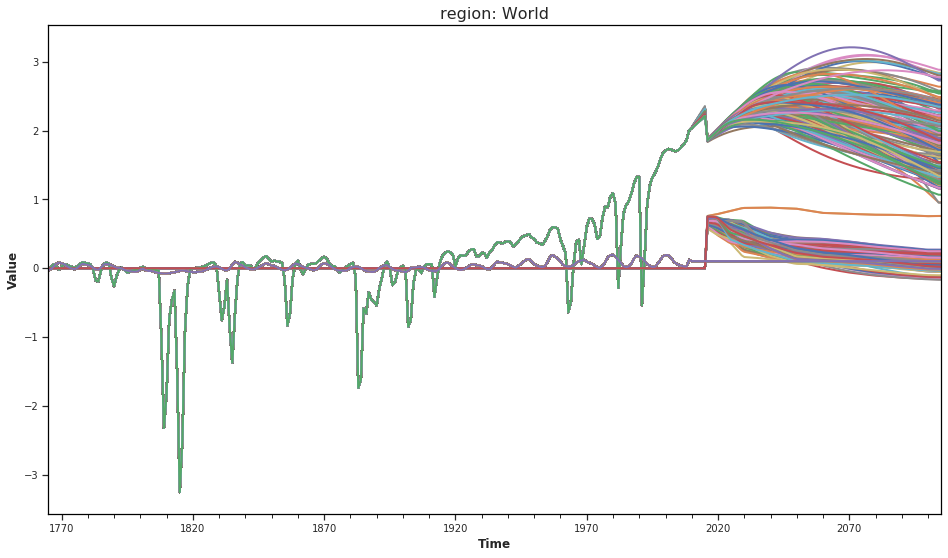

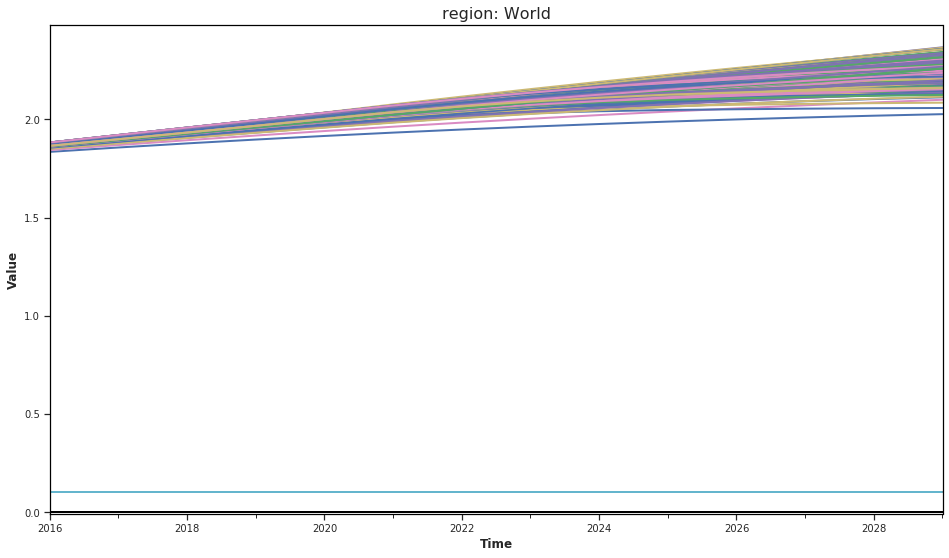

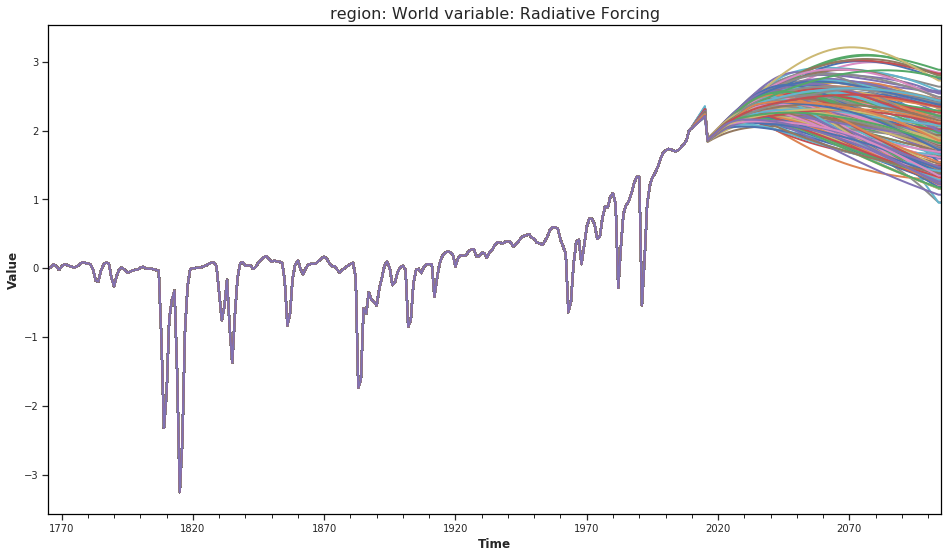

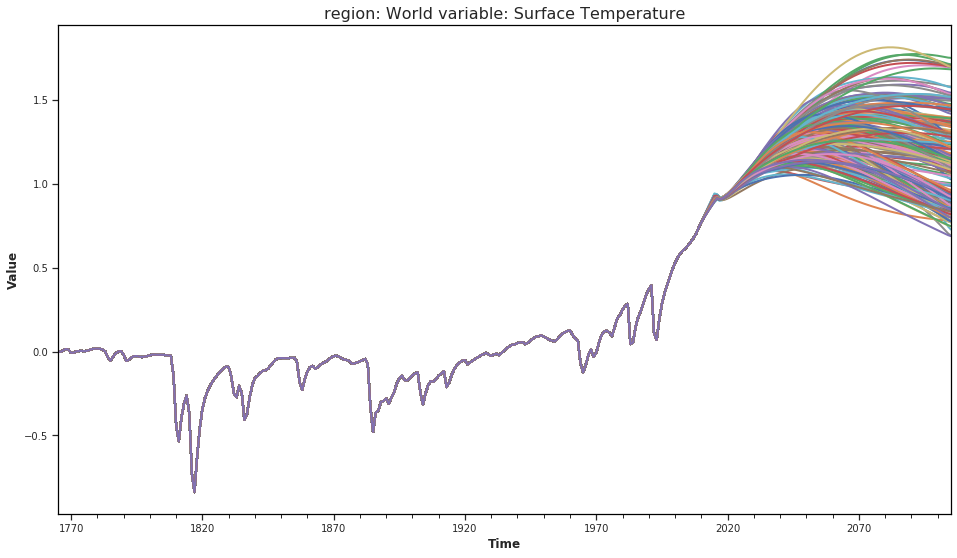

<IPython.core.display.Javascript object>

In [25]:
if SHOW_PLOTS or True:
    res_co2_rf_zero_nonco2_rf = non_co2_diagnosis_results.filter(
        zn_nonco2_diagnosis_option="co2_rf_zero_nonco2_rf"
    )
    res_co2_rf_zero_nonco2_rf.filter(
        variable=[
            "Radiative Forcing",
            "Radiative Forcing|Greenhouse Gases",
            "Radiative Forcing|Solar",
            "Radiative Forcing|Extra",
        ],
        region="World",
    ).line_plot(figsize=(16, 9))
    ax = res_co2_rf_zero_nonco2_rf.filter(
        variable=[
            "Radiative Forcing",
            "Radiative Forcing|Greenhouse Gases",
            #         "Radiative Forcing|Aerosols|Direct Effect",
            #         "Radiative Forcing|Aerosols|Indirect Effect",
            #         "Radiative Forcing|Tropospheric Ozone",
            #         "Radiative Forcing|Stratospheric Ozone",
            #         "AIR_CONTRAIL_RF",
            #         "AIR_H2O_RF",
            #         "AIR_CIRRUS_RF",
            #         "TOTAL_RF",
            #         "Radiative Forcing|CH4 Oxidation Stratospheric H2O",
            #         "Radiative Forcing|Land-use Change",
            #         "Radiative Forcing|Black Carbon on Snow",
            "Radiative Forcing|Solar",
        ],
        region="World",
        year=range(2016, 2030),
    ).line_plot(figsize=(16, 9))
    ax.axhline(0, color="black")

    res_co2_rf_zero_nonco2_rf.filter(
        variable="Radiative Forcing", region="World"
    ).line_plot(figsize=(16, 9))
    res_co2_rf_zero_nonco2_rf.filter(
        variable="Surface Temperature", region="World"
    ).line_plot(figsize=(16, 9))

### Overview of non-CO$_2$ options

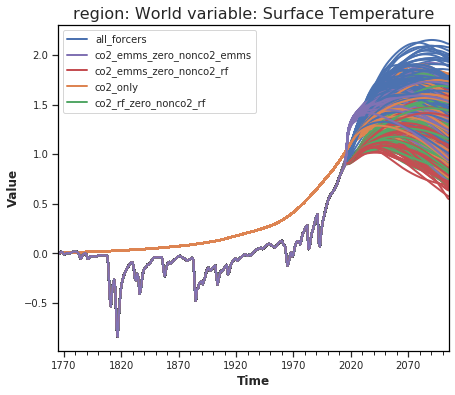

<IPython.core.display.Javascript object>

In [26]:
if SHOW_PLOTS or True:
    non_co2_diagnosis_results.filter(
        variable="Radiative Forcing", region="World"
    ).line_plot(color="zn_nonco2_diagnosis_option", figsize=(16, 9))

    ax = non_co2_diagnosis_results.filter(
        variable="Radiative Forcing", region="World", year=range(2010, 2051)
    ).line_plot(color="zn_nonco2_diagnosis_option", figsize=(16, 9))
    ax.axvline(datetime.datetime(2015, 1, 1), color="black", alpha=0.5)

    non_co2_diagnosis_results.filter(
        variable="Surface Temperature", region="World"
    ).line_plot(color="zn_nonco2_diagnosis_option")

    ax = non_co2_diagnosis_results.filter(
        variable="Surface Temperature", region="World", year=range(2010, 2051)
    ).line_plot(color="zn_nonco2_diagnosis_option", figsize=(16, 9))
    ax.axvline(datetime.datetime(2015, 1, 1), color="black", alpha=0.5)

    ScmDataFrame(
        non_co2_diagnosis_results.filter(
            variable="Surface Temperature", region="World", year=range(2000, 2101)
        ).relative_to_ref_period_mean(
            append_str="rel to 2006-2015", year=range(2006, 2015 + 1)
        )
    ).line_plot(color="zn_nonco2_diagnosis_option", figsize=(16, 9))

## Save output

Filter out data which applies to scenario only i.e. drop data after 2100.

In [27]:
non_co2_diagnosis_results = non_co2_diagnosis_results.filter(year=range(1, 2101))

<IPython.core.display.Javascript object>

Save all the runs for later analysis.

In [28]:
output = (
    df_append([diagnosis_runs, non_co2_diagnosis_results])
    .filter(region="World")
    .timeseries()
    .reset_index()
)
output.loc[
    output["zn_nonco2_diagnosis_option"].isnull(), "zn_nonco2_diagnosis_option"
] = "N/A"
output = ScmDataFrame(output)
save_scmdataframe(output, OUTPUT_RUNS)

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


<IPython.core.display.Javascript object>